In [1]:
include("./src/Integer.jl")

Main.Integer

In [2]:
using .Integer
using Combinatorics
using LinearAlgebra
using LaTeXStrings
using Plots

pyplot()

Plots.PyPlotBackend()

In [3]:
Na = 60; # number of atoms
Ls = 3; # number of wells

### The particle conserved basis

In [4]:
Hbs = Vector{Int64}[] 
ps = integer_partition(Na, Ls);
for p in ps
    append!(Hbs, collect(multiset_permutations(p, Ls)))
end

In [5]:
Lb = length(Hbs) # the dimension of the Hilbert space

1891

In [6]:
Lb_shouldbe = binomial(Na+Ls-1, Na)

1891

### The hopping Hamiltonian

In [7]:
H3s1 = hopping_pair(m=1, Na=Na, Hbs=Hbs);
H3s2 = hopping_pair(m=2, Na=Na, Hbs=Hbs);

In [8]:
H3s = H3s1 + H3s2;

In [9]:
Hhop = H3s + H3s';

### The onsite interaction

In [10]:
Honsite = zeros(Float64, Lb, Lb);

In [11]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            Honsite[j,k] = Hbs[j][1]^2 + Hbs[j][2]^2 + Hbs[j][3]^2 - Hbs[j][1] - Hbs[j][2] - Hbs[j][3]
        end
    end
end

### The tilt potential

In [12]:
function Htit(γ::Float64)
    Htit = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                Htit[j,k] = γ*Hbs[j][1] + 0*Hbs[j][2] - γ*Hbs[j][3]
            end

        end
    end
    return Htit
end

Htit (generic function with 1 method)

### Soft-core interactions

In [13]:
Λ(delta::Int64, d::Float64, C6::Float64, R::Float64) = C6 / ((delta)^6*d^6 + R^6)

Λ (generic function with 1 method)

In [14]:
# Here 'd' is the lattice constant.
function Hsc(d::Float64, C6::Float64, R::Float64)
    Hsc = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                Hsc[j,k] = Λ(0,d,C6,R)*(Hbs[j][1]*Hbs[j][1]+Hbs[j][2]*Hbs[j][2]+Hbs[j][3]*Hbs[j][3])+2*Λ(1,d,C6,R)*(Hbs[j][1]*Hbs[j][2]+Hbs[j][2]*Hbs[j][3])+2*Λ(2,d,C6,R)*(Hbs[j][1]*Hbs[j][3])
            end
        end
    end
    return Hsc
end

Hsc (generic function with 1 method)

### Parameters we gonna use for reproducing Gary's results

In [15]:
Λ(1, 1.0, 100.0, 2.0)

1.5384615384615385

In [16]:
Λ(2, 1.0, 100.0, 2.0)

0.78125

In [17]:
Λ(0, 1.0, 100.0, 2.0)

1.5625

### Construction of the full Hamiltonian

In [18]:
function Htot(;γ::Float64, J::Float64, g::Float64, d::Float64, C6::Float64, R::Float64)
    Htot = Htit(γ) - J*Hhop + (g/2)*Honsite + (1/2)*Hsc(d,C6,R)
    return Htot
end
    

Htot (generic function with 1 method)

### Plot with respect to $\gamma$
Here we will fix all parameters in function $\textbf{Htot}$ listed above except $\gamma$. Like we've stated as above, with all the parameters fixed, we have $\Lambda_0=1.5625$, $\Lambda_1\approx 1.54$ and $\Lambda_2\approx 0.78$ so that we approximately have $\Lambda_1\approx 2\Lambda_2$ (i.e., Gary's assumption).

In [19]:
J = 1.0
g = -1.56
d = 1.0
C6 = 100.0
R = 2.0
#gammas = -5.0:0.1:5.0
gammas = 0:0.5:10
eigs = zeros(Float64, Lb, length(gammas));

i1 = 1
for gamma in gammas
    eigs[:,i1] = eigvals(Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R))
    i1 += 1
end

In [20]:
p1 = plot(xlab=L"$\gamma$", ylab=L"$\epsilon$", legend=false);

In [21]:
for i in 1:Lb
    plot!(p1, gammas, eigs[i,:])
end

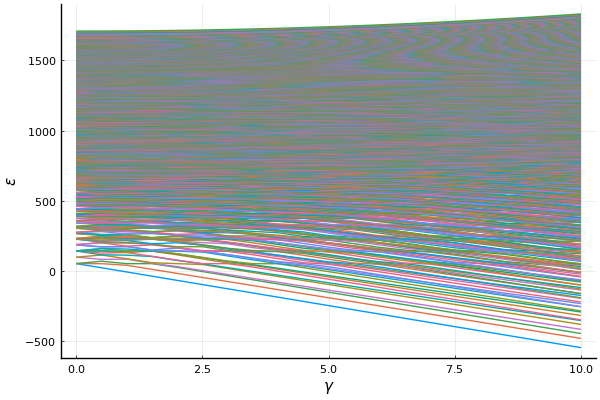

In [22]:
p1

### Level spacing distributions
Here we will apply eigenvalue unfolding onto eigenvalues.

In [34]:
# In our case, we take average every 7 levels, we drop (7-1)/2 spacings at either end.
v = 7;

# This is defined for later convenience.
f(x) = exp(-x);

#### Case 1. $\gamma=1.25$

In [24]:
eigs1 = eigvals(Htot(γ=1.25, J=J, g=g, d=d, C6=C6, R=R));

In [25]:
diffs1 = [eigs1[i+1]-eigs1[i] for i in 1:length(eigs1)-1]

In [26]:
index1 = Int((v-1)/2)
index2 = length(diffs1)-index1
diffs1_dropped = diffs1[index1:index2];

In [27]:
new_diffs1 = []
for i in 1:length(diffs1_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs1_dropped)
        append!(new_diffs1, diffs1_dropped[i]/average_spacing(diffs1_dropped, i, v))
    end
end

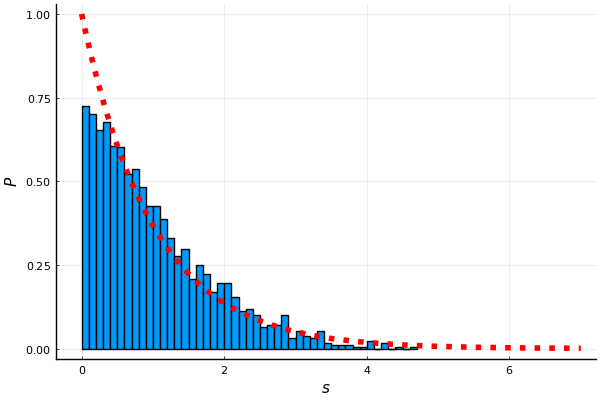

In [40]:
p2 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p2, new_diffs1, bins=50, normed=true)
plot!(f, 0, 7, linestyle=:dot, linewidth=4, color=:red)